In [3]:
import requests
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pathlib
import tarfile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2023-02-04 00:19:27.932957: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
url = "https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz"
r = requests.get(url, allow_redirects=True)
open("cora.tgz", "wb").write(r.content)

168052

In [5]:
tarball_path = pathlib.Path("datasets/housing.tgz")
if not tarball_path.is_file():
    pathlib.Path("datasets").mkdir(parents=True, exist_ok=True)
    with tarfile.open("cora.tgz") as datafile:
        datafile.extractall(path="datasets")
citationdata = pd.read_csv(pathlib.Path("datasets/cora/cora.cites"), sep="\t",header=None, names=["target", "source"],)
citationdata.sample(frac=1)

,target,source
554,1997,7032
4507,198653,1152896
2562,27627,686030
3456,63931,136766
499,1688,647413
...,...,...
3899,95594,95589
1247,6213,128
3058,40151,1104261
942,3243,368431


In [6]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
paperdata = pd.read_csv(pathlib.Path("datasets/cora/cora.content"), sep="\t", header=None, names=column_names,)
paperdata.shape

(2708, 1435)

In [7]:
paperdata.sample(20)

,paper_id,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,...,term_1424,term_1425,term_1426,term_1427,term_1428,term_1429,term_1430,term_1431,term_1432,subject
51,158098,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods
1134,650807,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
537,175256,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
2243,47682,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
12,109323,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods
2104,1153945,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
2348,71736,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Probabilistic_Methods
2611,523010,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Neural_Networks
2023,1153106,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Neural_Networks
1083,1132864,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


In [8]:
paperdata[["subject"]].value_counts()

subject               
Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
dtype: int64

In [9]:
class_values = sorted(paperdata["subject"].unique())
class_values

['Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory']

In [10]:
class_idx = {name: id for id, name in enumerate(class_values)}
class_idx

{'Case_Based': 0,
 'Genetic_Algorithms': 1,
 'Neural_Networks': 2,
 'Probabilistic_Methods': 3,
 'Reinforcement_Learning': 4,
 'Rule_Learning': 5,
 'Theory': 6}

In [11]:
paper_idx = {name: idx for idx, name in enumerate(sorted(paperdata["paper_id"].unique()))}
paper_idx

{35: 0,
 40: 1,
 114: 2,
 117: 3,
 128: 4,
 130: 5,
 164: 6,
 288: 7,
 424: 8,
 434: 9,
 463: 10,
 504: 11,
 506: 12,
 887: 13,
 906: 14,
 910: 15,
 936: 16,
 940: 17,
 941: 18,
 943: 19,
 1026: 20,
 1033: 21,
 1034: 22,
 1035: 23,
 1213: 24,
 1237: 25,
 1246: 26,
 1272: 27,
 1365: 28,
 1385: 29,
 1481: 30,
 1688: 31,
 1694: 32,
 1717: 33,
 1786: 34,
 1817: 35,
 1919: 36,
 1949: 37,
 1951: 38,
 1952: 39,
 1953: 40,
 1955: 41,
 1956: 42,
 1959: 43,
 1997: 44,
 1999: 45,
 2354: 46,
 2440: 47,
 2653: 48,
 2654: 49,
 2658: 50,
 2663: 51,
 2665: 52,
 2695: 53,
 2696: 54,
 2698: 55,
 2702: 56,
 3084: 57,
 3085: 58,
 3095: 59,
 3097: 60,
 3101: 61,
 3112: 62,
 3187: 63,
 3191: 64,
 3192: 65,
 3217: 66,
 3218: 67,
 3220: 68,
 3222: 69,
 3223: 70,
 3229: 71,
 3231: 72,
 3232: 73,
 3233: 74,
 3235: 75,
 3236: 76,
 3237: 77,
 3240: 78,
 3243: 79,
 3828: 80,
 3932: 81,
 4274: 82,
 4329: 83,
 4330: 84,
 4335: 85,
 4553: 86,
 4584: 87,
 4637: 88,
 4649: 89,
 4660: 90,
 4804: 91,
 4878: 92,
 4983: 93

In [12]:
paperdata["paper_id"] = paperdata["paper_id"].apply(lambda name: paper_idx[name])
paperdata["subject"] = paperdata["subject"].apply(lambda value: class_idx[value])
citationdata["source"] = citationdata["source"].apply(lambda name: paper_idx[name])
citationdata["target"] = citationdata["target"].apply(lambda name: paper_idx[name])

In [13]:
paperdata.head()

,paper_id,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,...,term_1424,term_1425,term_1426,term_1427,term_1428,term_1429,term_1430,term_1431,term_1432,subject
0,462,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,2
1,1911,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,5
2,2002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,248,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
4,519,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [14]:
plt.figure(figsize=(10,10))
colors = paperdata["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citationdata.sample(n=150))
subjects = list(paperdata[paperdata["paper_id"].isin(list(cora_graph.nodes))]["subject"])
subjects

[4,
 6,
 2,
 2,
 6,
 2,
 3,
 0,
 2,
 0,
 3,
 3,
 2,
 2,
 3,
 1,
 2,
 6,
 5,
 1,
 1,
 2,
 0,
 6,
 2,
 2,
 3,
 3,
 2,
 0,
 2,
 3,
 3,
 3,
 2,
 4,
 4,
 6,
 6,
 6,
 3,
 6,
 2,
 6,
 2,
 0,
 2,
 6,
 4,
 6,
 3,
 4,
 1,
 0,
 4,
 3,
 2,
 2,
 0,
 2,
 2,
 4,
 4,
 4,
 6,
 2,
 2,
 0,
 2,
 2,
 2,
 3,
 0,
 4,
 6,
 2,
 4,
 5,
 2,
 2,
 2,
 1,
 1,
 0,
 0,
 1,
 0,
 2,
 2,
 0,
 2,
 1,
 6,
 0,
 1,
 2,
 4,
 2,
 3,
 1,
 1,
 1,
 6,
 1,
 6,
 6,
 3,
 3,
 0,
 6,
 0,
 2,
 1,
 1,
 2,
 0,
 1,
 0,
 3,
 1,
 1,
 6,
 6,
 1,
 1,
 0,
 0,
 1,
 2,
 1,
 2,
 2,
 5,
 3,
 6,
 2,
 6,
 1,
 1,
 1,
 6,
 2,
 1,
 1,
 3,
 6,
 2,
 6,
 1,
 2,
 1,
 2,
 2,
 0,
 1,
 3,
 1,
 6,
 6,
 1,
 2,
 6,
 1,
 0,
 0,
 2,
 6,
 0,
 1,
 1,
 2,
 2,
 6,
 1,
 1,
 2,
 1,
 3,
 1,
 2,
 6,
 2,
 2,
 2,
 2,
 4,
 1,
 1,
 3,
 6,
 3,
 6,
 2,
 0,
 6,
 1,
 2,
 1,
 1,
 2,
 2,
 4,
 3,
 3,
 3,
 2,
 2,
 1,
 2,
 0,
 0,
 3,
 1,
 1,
 2,
 3,
 6,
 5,
 2,
 3,
 4,
 0,
 3,
 1,
 4,
 2,
 2,
 1,
 5,
 0,
 2,
 3,
 1,
 0,
 1,
 4,
 2,
 3,
 3,
 6,
 6,
 2,
 0,
 6,
 6,
 2,
 2,
 6,
 3,
 3,


<Figure size 1000x1000 with 0 Axes>

In [15]:
#nx.draw_spring(cora_graph, node_size = 15, node_colour = subjects)

In [16]:
#nx.drawing.layout.spring_layout(cora_graph)

In [17]:
paperdata.groupby("subject")

In [18]:
train_data, test_data = [], []

for _, group_data in paperdata.groupby("subject"):
    random_selection = np.random.rand(len(group_data.index)) <= 0.8
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (2188, 1435)
Test data shape: (520, 1435)


In [19]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 100
batch_size = 256

In [33]:
def run_exp(model, x_train, y_train):
    model.compile(optimizer = keras.optimizers.Adam(learning_rate), loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = [keras.metrics.SparseCategoricalAccuracy(name="acc")])
    early_stopping = keras.callbacks.EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)
    history = model.fit(x=x_train,y=y_train,epochs=num_epochs,batch_size=batch_size,validation_split=0.15,callbacks=[early_stopping])
    return history

In [21]:
def plot_learning_curve(history):
    fig,(ax1,ax2) = plt.subplots(1,2, figsize = (15,5))
    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

In [22]:
def createffn(hidden_units, dropout_rate, name=None):
    fnnlayers = []
    for units in hidden_units:
        fnnlayers.append(layers.BatchNormalization())
        fnnlayers.append(layers.Dropout(dropout_rate))
        fnnlayers.append(layers.Dense(units, activation=tf.nn.gelu))
    return keras.Sequential(fnnlayers, name=name)

In [23]:
class_idx

{'Case_Based': 0,
 'Genetic_Algorithms': 1,
 'Neural_Networks': 2,
 'Probabilistic_Methods': 3,
 'Reinforcement_Learning': 4,
 'Rule_Learning': 5,
 'Theory': 6}

In [25]:
paper_idx

{35: 0,
 40: 1,
 114: 2,
 117: 3,
 128: 4,
 130: 5,
 164: 6,
 288: 7,
 424: 8,
 434: 9,
 463: 10,
 504: 11,
 506: 12,
 887: 13,
 906: 14,
 910: 15,
 936: 16,
 940: 17,
 941: 18,
 943: 19,
 1026: 20,
 1033: 21,
 1034: 22,
 1035: 23,
 1213: 24,
 1237: 25,
 1246: 26,
 1272: 27,
 1365: 28,
 1385: 29,
 1481: 30,
 1688: 31,
 1694: 32,
 1717: 33,
 1786: 34,
 1817: 35,
 1919: 36,
 1949: 37,
 1951: 38,
 1952: 39,
 1953: 40,
 1955: 41,
 1956: 42,
 1959: 43,
 1997: 44,
 1999: 45,
 2354: 46,
 2440: 47,
 2653: 48,
 2654: 49,
 2658: 50,
 2663: 51,
 2665: 52,
 2695: 53,
 2696: 54,
 2698: 55,
 2702: 56,
 3084: 57,
 3085: 58,
 3095: 59,
 3097: 60,
 3101: 61,
 3112: 62,
 3187: 63,
 3191: 64,
 3192: 65,
 3217: 66,
 3218: 67,
 3220: 68,
 3222: 69,
 3223: 70,
 3229: 71,
 3231: 72,
 3232: 73,
 3233: 74,
 3235: 75,
 3236: 76,
 3237: 77,
 3240: 78,
 3243: 79,
 3828: 80,
 3932: 81,
 4274: 82,
 4329: 83,
 4330: 84,
 4335: 85,
 4553: 86,
 4584: 87,
 4637: 88,
 4649: 89,
 4660: 90,
 4804: 91,
 4878: 92,
 4983: 93

In [31]:
featurenames = set(paperdata.columns) - {"paper_id","subject"}
nfeatures = len(featurenames)
nclasses = len(class_idx)
x_train = train_data[featurenames].to_numpy()
x_test = test_data[featurenames].to_numpy()

y_train = train_data["subject"]
y_test = test_data["subject"]


/tmp/ipykernel_889/362588152.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x_train = train_data[featurenames].to_numpy()
/tmp/ipykernel_889/362588152.py:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x_test = test_data[featurenames].to_numpy()


In [30]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(nfeatures,), name="input_features")
    x = createffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = createffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, nclasses, dropout_rate)
baseline_model.summary()

Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features (InputLayer)    [(None, 1433)]       0           []                               
                                                                                                  
 ffn_block1 (Sequential)        (None, 32)           52804       ['input_features[0][0]']         
                                                                                                  
 ffn_block2 (Sequential)        (None, 32)           2368        ['ffn_block1[0][0]']             
                                                                                                  
 skip_connection2 (Add)         (None, 32)           0           ['ffn_block1[0][0]',             
                                                                  'ffn_block2[0][0]']      

In [34]:
history = run_exp(baseline_model, x_train, y_train)

/home/divijkhaitan/anaconda3/envs/gnnenv/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Epoch 1/100
8/8 [==============================] - 3s 97ms/step - loss: 3.2738 - acc: 0.1904 - val_loss: 1.7916 - val_acc: 0.3435
Epoch 2/100
8/8 [==============================] - 0s 38ms/step - loss: 2.4890 - acc: 0.2641 - val_loss: 1.8051 - val_acc: 0.3435
Epoch 3/100
8/8 [==============================] - 0s 45ms/step - loss: 2.1550 - acc: 0.2577 - val_loss: 1.8305 - val_acc: 0.3435
Epoch 4/100
8/8 [==============================] - 0s 50ms/step - loss: 1.9827 - acc: 0.2910 - val_loss: 1.7836 - val_acc: 0.3435
Epoch 5/100
8/8 [==============================] - 1s 72ms/step - loss: 1.8721 - acc: 0.3287 - val_loss: 1.7512 - val_acc: 0.3435
Epoch 6/100
8/8 [==============================] - 1s 74ms/step - loss: 1.7775 - acc: 0.3507 - val_loss: 1.7415 - val_acc: 0.4043
Epoch 7/100
8/8 [==============================] - 1s 72ms/step - loss: 1.6551 - acc: 0.4024 - val_loss: 1.6658 - val_acc: 0.3951
Epoch 8/100
8/8 [==============================] - 0s 48ms/step - loss: 1.5733 - acc: 0.43

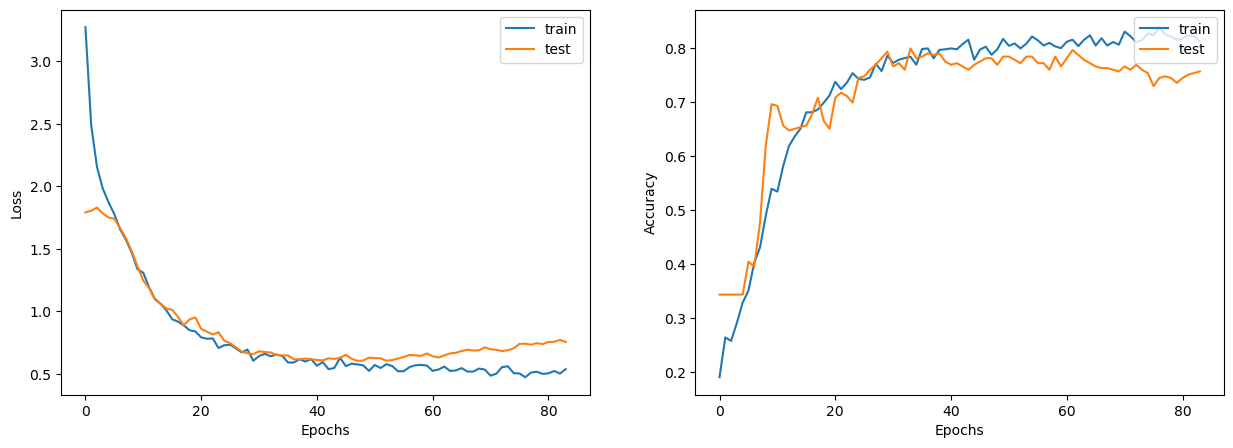

In [35]:
plot_learning_curve(history)

In [36]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 77.12%


In [41]:
def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []
    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)

    return np.array(instances)

def display_class_probabilities(probabilities):
     for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")

In [44]:
new_instances = generate_random_instances(10)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

1/1 [==============================] - 0s 66ms/step
Instance 1:
- Case_Based: 14.4%
- Genetic_Algorithms: 0.8%
- Neural_Networks: 14.96%
- Probabilistic_Methods: 55.58%
- Reinforcement_Learning: 0.31%
- Rule_Learning: 0.78%
- Theory: 13.17%
Instance 2:
- Case_Based: 1.32%
- Genetic_Algorithms: 3.4%
- Neural_Networks: 25.79%
- Probabilistic_Methods: 34.08%
- Reinforcement_Learning: 2.45%
- Rule_Learning: 2.3%
- Theory: 30.65%
Instance 3:
- Case_Based: 2.02%
- Genetic_Algorithms: 11.67%
- Neural_Networks: 57.88%
- Probabilistic_Methods: 7.48%
- Reinforcement_Learning: 4.65%
- Rule_Learning: 8.37%
- Theory: 7.93%
Instance 4:
- Case_Based: 1.01%
- Genetic_Algorithms: 18.02%
- Neural_Networks: 38.0%
- Probabilistic_Methods: 20.41%
- Reinforcement_Learning: 18.21%
- Rule_Learning: 0.52%
- Theory: 3.83%
Instance 5:
- Case_Based: 0.49%
- Genetic_Algorithms: 0.58%
- Neural_Networks: 6.3%
- Probabilistic_Methods: 84.32%
- Reinforcement_Learning: 4.13%
- Rule_Learning: 0.42%
- Theory: 3.75%
Insta